In [ ]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

## Read the dataset

In [ ]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

In [ ]:
def plot_image_and_mask(image, masks):
    # Convert images to uint8
    image = (image * 255).byte()
    
    # Convert masks to bool
    masks = masks.bool()
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0).numpy()
    
    # Plot the image
    plt.imshow(image_with_masks)
    plt.show()
    

In [ ]:
from dataloaders.solar_dk_dataset import SolarDKDataset
import torchvision.transforms.v2 as transforms

train_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/train"
validation_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/val"

transform = transforms.Compose(    [
        transforms.ToDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SolarDKDataset(train_folder, transform=transform)
validation_dataset = SolarDKDataset(validation_folder, transform=transform)

In [ ]:
image, mask = train_dataset[10698]
plot_image_and_mask(image, mask)

### Load the dataset

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataset = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=4)

### Train the model

In [ ]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
# from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [ ]:
model = DeepLabModel(num_classes=1)
# model = UNetModel(n_channels=3, n_classes=1)

# model = MaskRCNNModel(num_classes=1)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

base_model = BaseModel(model, loss_fn, optimizer)
trainer = pl.Trainer(max_epochs=10, min_epochs=5)

In [ ]:
for image, label in train_dataloader:
    # Print the size of the image and label
    print(image.size(), label.size())  
    break

In [ ]:
# trainer.fit(base_model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataset)

tensor([[[-222838.0625, -222838.0625, -222838.0625,  ..., -255428.9531, -255428.9531, -255428.9531],
         [-222838.0625, -222838.0625, -222838.0625,  ..., -255428.9531, -255428.9531, -255428.9531],
         [-222838.0625, -222838.0625, -222838.0625,  ..., -255428.9531, -255428.9531, -255428.9531],
         ...,
         [-209577.6250, -209577.6250, -209577.6250,  ..., -249373.7812, -249373.7812, -249373.7812],
         [-209577.6250, -209577.6250, -209577.6250,  ..., -249373.7812, -249373.7812, -249373.7812],
         [-209577.6250, -209577.6250, -209577.6250,  ..., -249373.7812, -249373.7812, -249373.7812]]])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


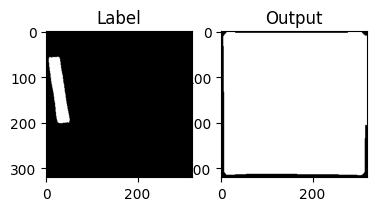

In [49]:
import torch
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
from PIL import Image

test_folder = "data/solardk_dataset_neurips_v2/herlev_test/test"

model = BaseModel.load_from_checkpoint("lightning_logs/version_204950/checkpoints/epoch=9-step=1680.ckpt")

transform = transforms.Compose(
    [
        transforms.ToDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_dataset = SolarDKDataset(test_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Estimate the model on the test set
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        output = model(image)[0]
    
        print(output)
    
        # output_predictions = output.argmax(0)
        output_predictions = (output < -400000).squeeze()
        
        print(output_predictions)
        
        label = label[0].squeeze()
        
        plt.subplot(1, 3, 2)
        plt.imshow(label, cmap="gray")
        plt.title("Label")
        
        plt.subplot(1, 3, 3)
        r = Image.fromarray(output_predictions.byte().cpu().numpy())
        plt.imshow(r, cmap="gray")
        plt.title("Output")
        
        plt.show()
        
        break
        